In [203]:
# lots and lots of imports!!!!
import pandas as pd
from termcolor import colored
from collections import Counter
import requests
import ast
import os
import json
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Dropout, Flatten, Add, Activation
from sklearn.metrics import precision_score, recall_score, f1_score, hamming_loss, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import random
import tensorflow as tf
import numpy as np
from PIL import Image
from io import BytesIO

In [335]:
# model data
input_shape = (64, 64, 3)
num_classes = len(top_genres)

In [336]:
# make dataframes from the csv files
albums_df = pd.read_csv('albums.csv', sep='\t')

# clean up the fucked up "dictionary" that the data came in
albums_df['artist_name'] = albums_df['artists'].apply(lambda x: x.split(':')[1] if pd.notnull(x) else x)
albums_df['artist_name'] = albums_df['artist_name'].apply(lambda x: x.split(',')[0] if pd.notnull(x) else x)
albums_df['artist_name'] = albums_df['artist_name'].apply(lambda x: x.replace("'",'').replace("}",'').replace("{",''))

albums_df['artist_id'] = albums_df['artists'].apply(lambda x: x.split(':')[0] if pd.notnull(x) else x)
albums_df['artist_id'] = albums_df['artist_id'].apply(lambda x: x.split(',')[0] if pd.notnull(x) else x)
albums_df['artist_id'] = albums_df['artist_id'].apply(lambda x: x.replace("'",'').replace("}",'').replace("{",''))
albums_df['album_name'] = albums_df['name']
artists_df = pd.read_csv('artists.csv', sep='\t')

merged_df = pd.merge(albums_df, artists_df, on='artist_id', how='left')
data_df = merged_df[['album_name', 'album_id', 'artist_name', 'genres', 'image_url_x']].copy()
data_df.columns = ['album_name', 'album_id', 'artist_name', 'genres', 'image_url']
data_df['genres'] = data_df['genres'].apply(lambda x: x.replace(" '",'').replace("' ",'').replace("'",'').replace("[",'').replace("]",'').split(',') if isinstance(x, str) else [])

top_genres = ['rock', 'hip hop', 'country']

# remove all genres that arent 'top genres'
data_df['genres'] = data_df['genres'].apply(lambda genres: [genre for genre in genres if genre in top_genres])

# keep only unique genres (drop if rock and country exist in same album)
data_df = data_df[data_df['genres'].apply(lambda x: len(x) == 1)]
data_df.reset_index(drop=True, inplace=True)

# turn the genres into binary
data_df['genre_binary'] = data_df['genres'].apply(lambda genres: [1 if genre in genres else 0 for genre in top_genres])
# get the quantity of each genre
genre_sums = np.sum(np.array(data_df['genre_binary'].tolist()), axis=0)

for i in range(len(top_genres)):
    print(f'{top_genres[i]:12} has {genre_sums[i]} albums')


rock         has 4473 albums
hip hop      has 1528 albums
country      has 1296 albums


In [337]:
def process_image(image_id):
    try:
        # Construct the file path
        file_path = f"album_art/{image_id}.jpg"

        # Open the image file
        with Image.open(file_path) as img:
            # Resize the image and convert to RGB
            img = img.resize((input_shape[0], input_shape[1])).convert('RGB')

            # Convert the image to a numpy array
            img_array = np.array(img)

            return img_array
    except (FileNotFoundError, OSError):
        # Return None or a placeholder if the image is not found or an error occurs
        return None

data_df['image_data'] = [process_image(image_id) for image_id in data_df['album_id']]

# remove all rows where the image data is empty for some reason
data_df = data_df[data_df['image_data'].notnull()]

In [338]:
genre_binary_array = np.array(data_df['genre_binary'].tolist())
min_count = np.min(np.sum(genre_binary_array, axis=0))
balanced_df = pd.DataFrame()
for i in range(genre_binary_array.shape[1]):
    # Find indices of rows where the genre is present
    genre_indices = np.where(genre_binary_array[:, i] == 1)[0]
    
    # Randomly select min_count indices
    selected_indices = np.random.choice(genre_indices, min_count, replace=False)
    
    # Append selected rows to the balanced DataFrame
    balanced_df = pd.concat([balanced_df, data_df.iloc[selected_indices]])

# Reset index of the balanced DataFrame
balanced_df.reset_index(drop=True, inplace=True)

# Print the new column sums for verification
new_column_sums = np.sum(np.array(balanced_df['genre_binary'].tolist()), axis=0)
for i in range(len(top_genres)):
    print(f'{top_genres[i]} has {new_column_sums[i]} albums')

rock has 1121 albums
hip hop has 1121 albums
country has 1121 albums


In [346]:
def residual_block(x, filters, kernel_size=(3, 3)):
    # save shortcut
    shortcut = x

    # conv2d
    x = Conv2D(filters, kernel_size=kernel_size, padding='same')(x)
    x = Activation('relu')(x)

    # apply projection shortcut
    x = Conv2D(filters, kernel_size=kernel_size, padding='same')(x)
    x = Add()([x, Conv2D(filters, kernel_size=(1, 1), padding='same')(shortcut)])
    x = Activation('relu')(x)
    return x

input_tensor = Input(shape=input_shape)

x = Conv2D(32, (7, 7), strides=(2, 2), padding='same', activation='relu')(input_tensor)
x = MaxPooling2D((3, 3), strides=(2, 2))(x)

x = residual_block(x, 64)
x = residual_block(x, 64)
x = residual_block(x, 128)

x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output_tensor = Dense(num_classes, activation='softmax')(x)  # Use 'sigmoid' for multi-label classification

# Create the model
model = Model(inputs=input_tensor, outputs=output_tensor)

# Compile the model
model.compile(loss='binary_crossentropy',  # Use binary crossentropy for multi-label classification
              optimizer='adam',
              metrics=['accuracy'])

# Model summary
model.summary()

Model: "model_22"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_33 (InputLayer)       [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d_275 (Conv2D)         (None, 32, 32, 32)           4736      ['input_33[0][0]']            
                                                                                                  
 max_pooling2d_44 (MaxPooli  (None, 15, 15, 32)           0         ['conv2d_275[0][0]']          
 ng2D)                                                                                            
                                                                                                  
 conv2d_276 (Conv2D)         (None, 15, 15, 64)           18496     ['max_pooling2d_44[0][0

In [348]:
X = np.array(balanced_df['image_data'].tolist()) / 255.0
y = np.array(balanced_df['genre_binary'].tolist())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.1)

Epoch 1/5
76/76 [==============================] - 28s 362ms/step - loss: 0.6398 - accuracy: 0.3424 - val_loss: 0.6416 - val_accuracy: 0.3160
Epoch 2/5
76/76 [==============================] - 27s 353ms/step - loss: 0.6352 - accuracy: 0.3767 - val_loss: 0.6365 - val_accuracy: 0.3532
Epoch 3/5
76/76 [==============================] - 27s 354ms/step - loss: 0.6323 - accuracy: 0.3903 - val_loss: 0.6373 - val_accuracy: 0.3383
Epoch 4/5
76/76 [==============================] - 27s 354ms/step - loss: 0.6268 - accuracy: 0.4188 - val_loss: 0.6308 - val_accuracy: 0.4089
Epoch 5/5
76/76 [==============================] - 27s 356ms/step - loss: 0.6137 - accuracy: 0.4581 - val_loss: 0.6310 - val_accuracy: 0.3569


In [349]:
# Load your model (assuming it's already trained and saved)
# model = load_model('path_to_your_model.h5')

# Making predictions on the test set
y_pred = model.predict(X_test)

# Pick the genre with the highest probability for each prediction
y_pred_max = np.argmax(y_pred, axis=1)

# Convert the index of the maximum predicted genre to its label
predicted_genres = [top_genres[idx] for idx in y_pred_max]

# Convert binary arrays back to genre labels for actual genres
mlb = MultiLabelBinarizer(classes=top_genres)
mlb.fit([top_genres])
y_test_genres = mlb.inverse_transform(y_test)

# Convert list of tuples to list of strings (since each tuple will have only one element)
y_test_genres = [g[0] if g else 'None' for g in y_test_genres]

# Create a DataFrame for comparison
comparison_df = pd.DataFrame({'Actual Genres': y_test_genres, 'Predicted Genres': predicted_genres})

# Display a few examples
print(comparison_df.sample(10))

22/22 [==============================] - 2s 101ms/step
    Actual Genres Predicted Genres
154       country          hip hop
586       hip hop          country
580       hip hop          country
532       hip hop          hip hop
533       country          hip hop
472       country          hip hop
185       country             rock
165          rock          hip hop
658          rock             rock
237       country             rock


In [350]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Loss: {loss}, Accuracy: {accuracy}")

22/22 [==============================] - 2s 98ms/step - loss: 0.6128 - accuracy: 0.4383
Loss: 0.6128348112106323, Accuracy: 0.4383358061313629


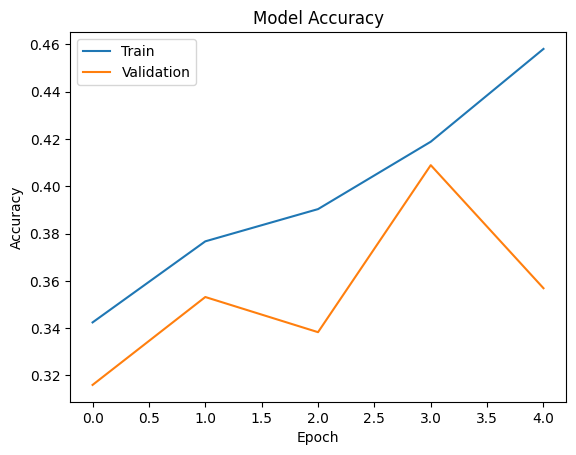

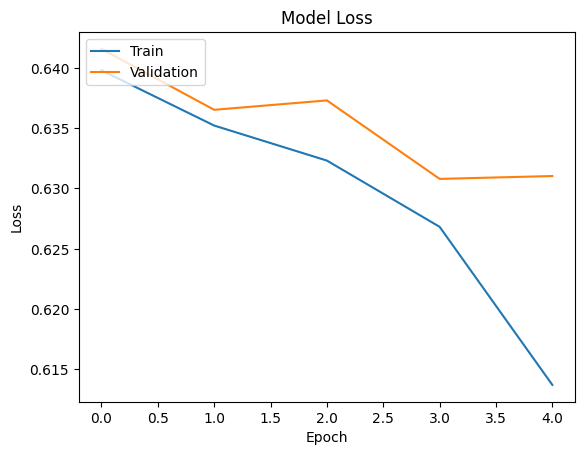

In [351]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

22/22 [==============================] - 2s 99ms/step


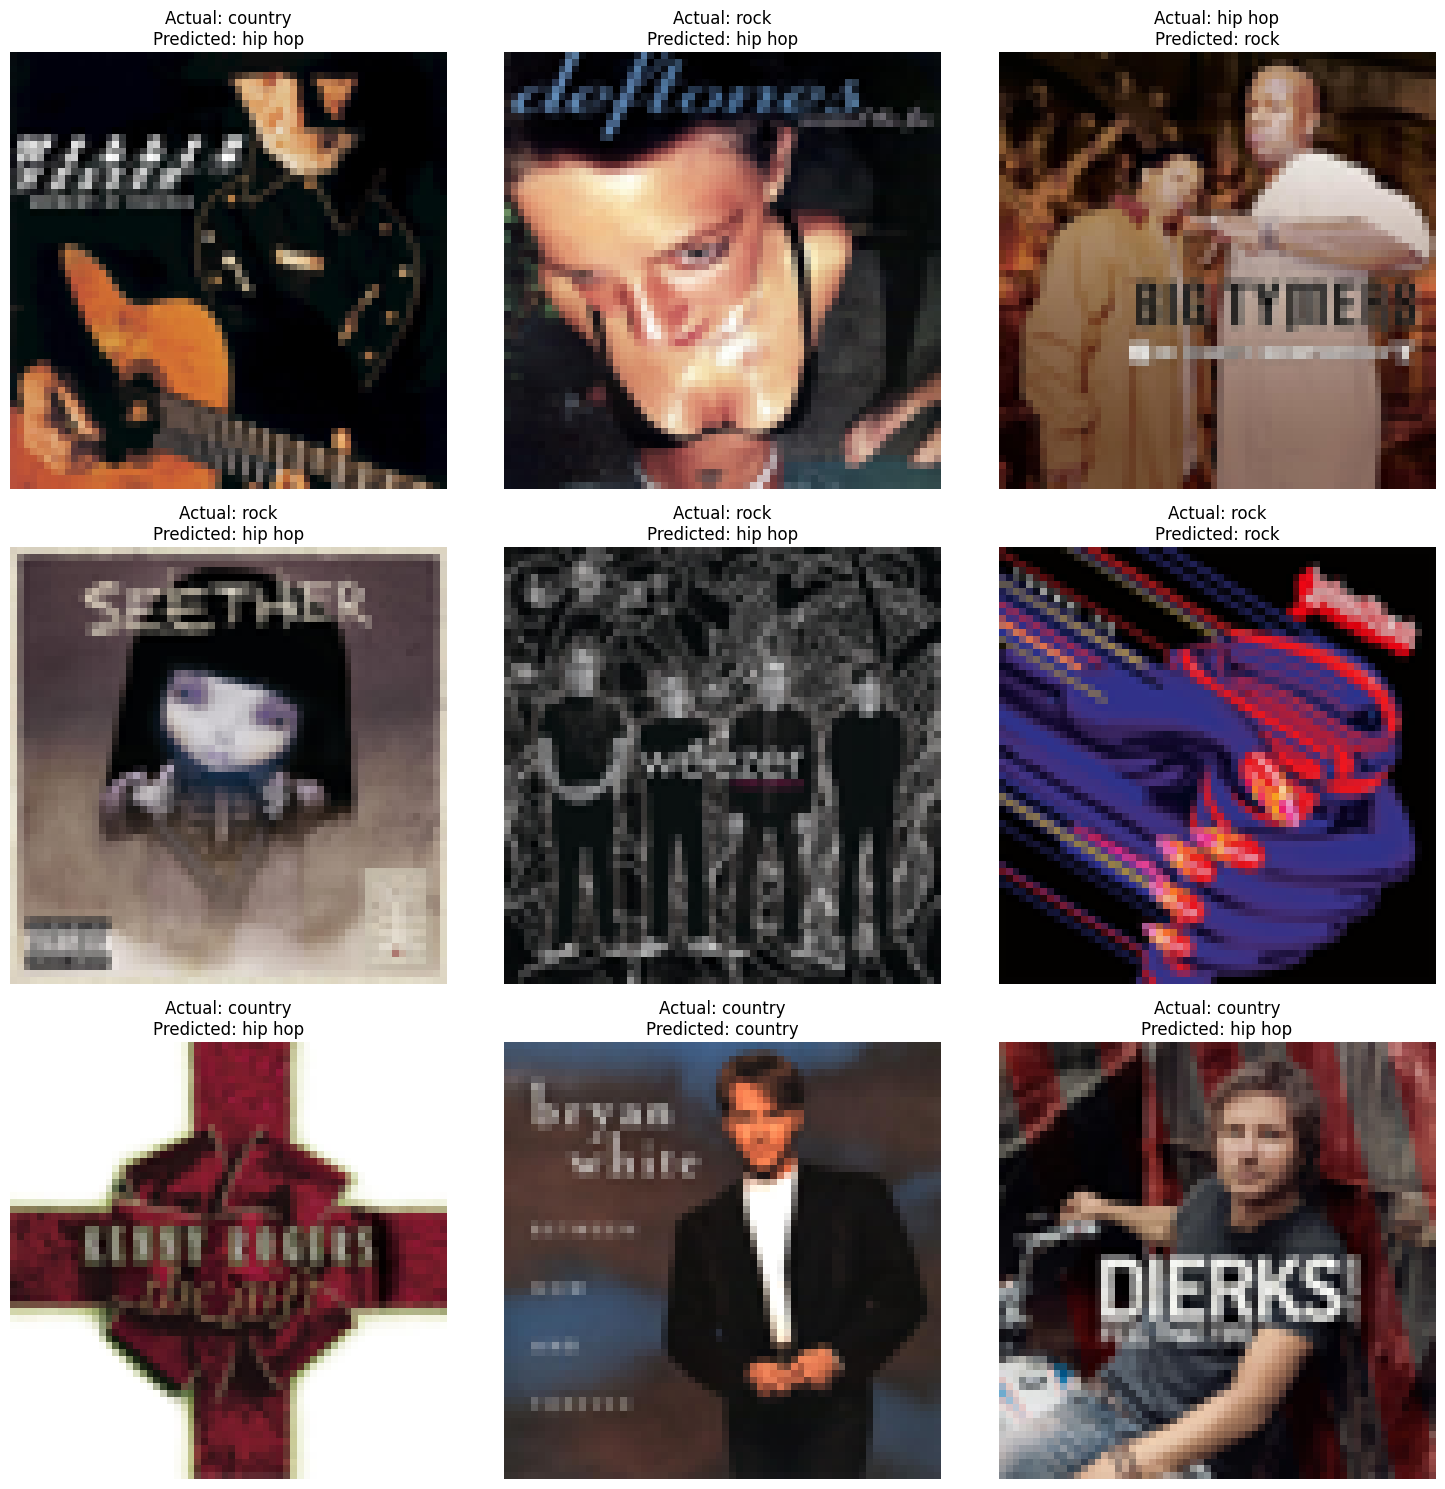

In [352]:
# Making predictions on the test set
y_pred = model.predict(X_test)

# Pick the genre with the highest probability for each prediction
y_pred_max = np.argmax(y_pred, axis=1)

# Convert the index of the maximum predicted genre to its label
predicted_genres = [top_genres[idx] for idx in y_pred_max]

# Convert binary arrays back to genre labels for actual genres
mlb = MultiLabelBinarizer(classes=top_genres)
mlb.fit([top_genres])
y_test_genres = mlb.inverse_transform(y_test)
y_test_genres = [g[0] if g else 'None' for g in y_test_genres]

# Select 9 random samples from the test set
sample_indices = np.random.choice(X_test.shape[0], 9, replace=False)
sample_images = X_test[sample_indices]
sample_actual_genres = [y_test_genres[i] for i in sample_indices]
sample_predicted_genres = [predicted_genres[i] for i in sample_indices]

# Plotting the images with actual and predicted genres
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.flatten()

for idx, ax in enumerate(axes):
    # Display image
    ax.imshow(sample_images[idx])
    ax.axis('off')
    # Title with actual and predicted genres
    ax.set_title(f"Actual: {sample_actual_genres[idx]}\nPredicted: {sample_predicted_genres[idx]}")

plt.tight_layout()
plt.show()

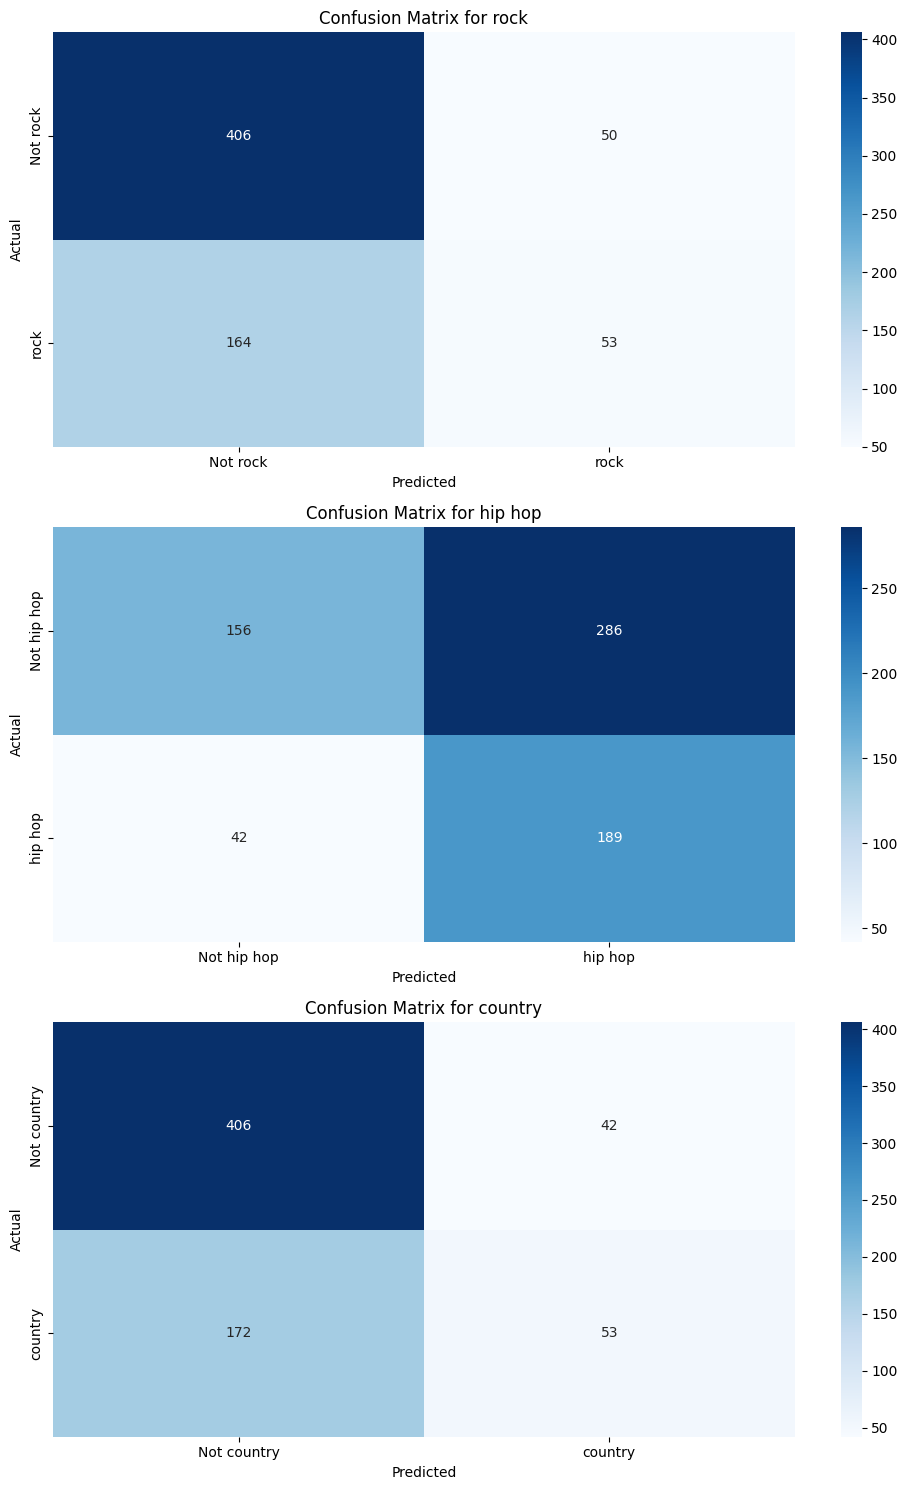

In [364]:
def plot_confusion_matrix(cm, genre_name, ax):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f'Confusion Matrix for {genre_name}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.xaxis.set_ticklabels(['Not ' + genre_name, genre_name])
    ax.yaxis.set_ticklabels(['Not ' + genre_name, genre_name])

    
y_pred_binary = np.zeros_like(y_pred)
y_pred_binary[np.arange(len(y_pred)), np.argmax(y_pred, axis=1)] = 1
# Create a new list with the maximum value highlighted
fig, axes = plt.subplots(len(top_genres), 1, figsize=(10, len(top_genres) * 5))

if len(top_genres) == 1:
    axes = [axes]

for i, genre in enumerate(top_genres):
    # Extract binary predictions and actuals for this genre
    y_true = y_test[:, i]
    y_pred_genre = y_pred_binary[:, i]

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred_genre)

    # Plot confusion matrix
    plot_confusion_matrix(cm, genre, axes[i] if len(top_genres) > 1 else axes)

plt.tight_layout()
plt.show()
